2025-07-02 21:07:21.507892: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 21:07:21.508295: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 21:07:21.510316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-02 21:07:21.515411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751501241.524174 2903900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751501241.52

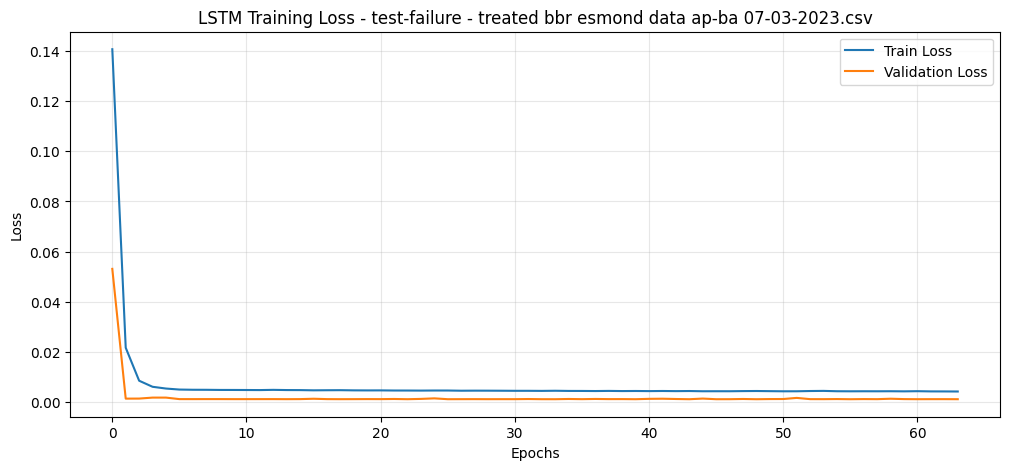

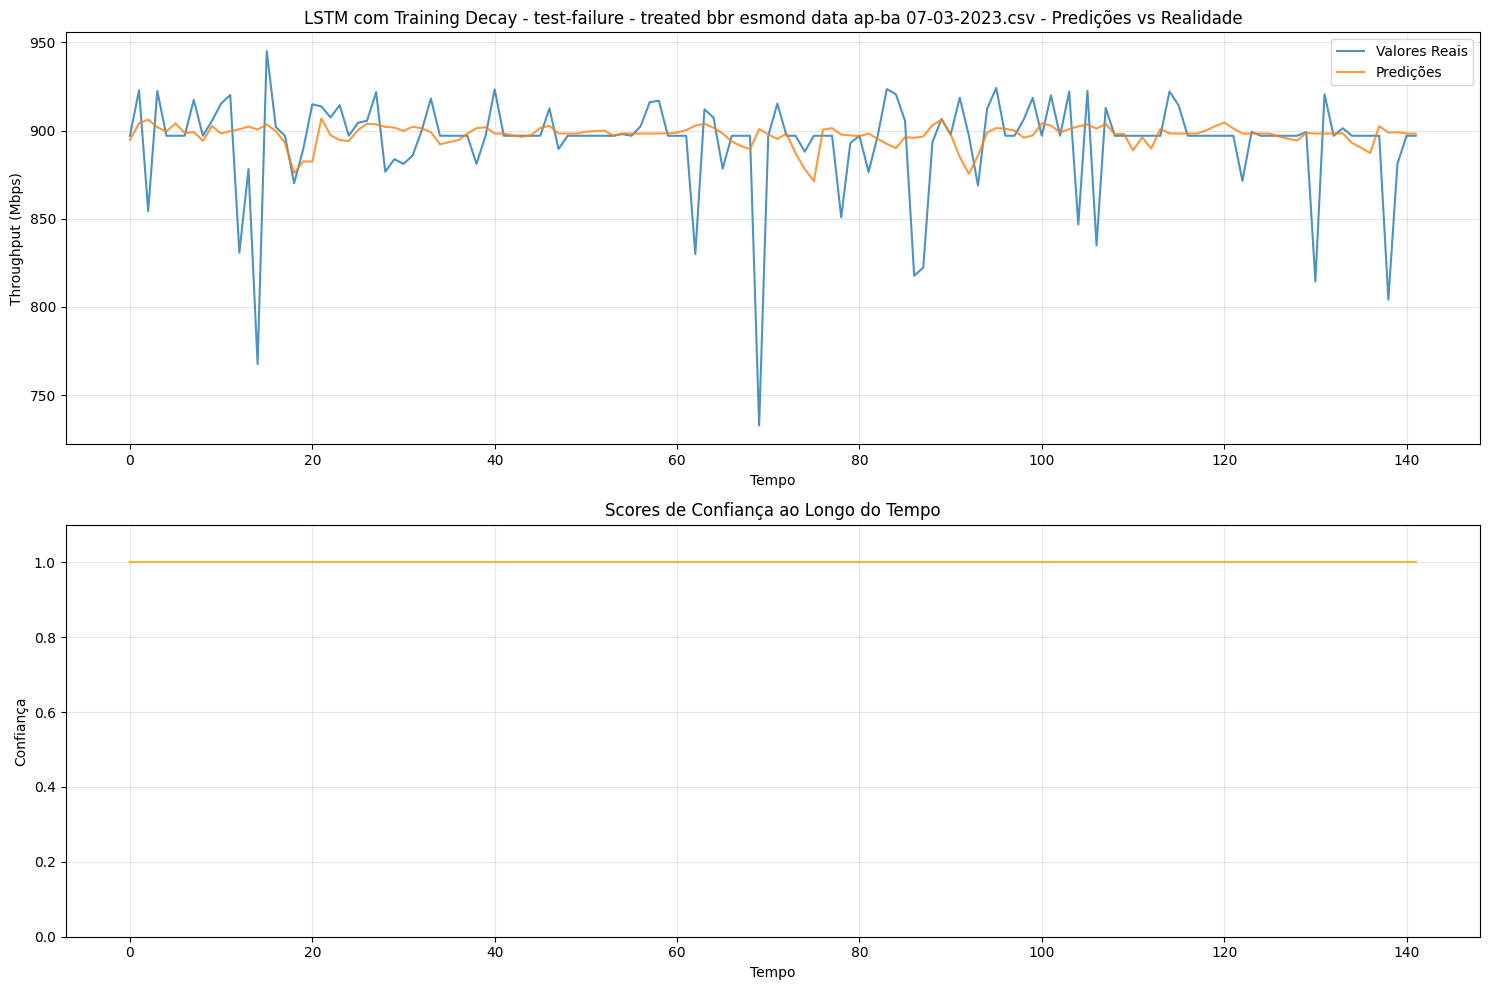


Treinamento concluído! Resultados salvos em:
- Log: training_output.txt
- Métricas: ../../results/bi-lstm/evaluation_decay.json
- Modelos: ../../modelo_salvo


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow.keras as keras
import json

# ===================================================================================
# FUNÇÕES AUXILIARES E UTILITÁRIAS
# ===================================================================================

def bits_para_megabits(df, col_vaz):
    """Converte bits para megabits e trata valores faltantes"""
    df[col_vaz] = df[col_vaz] / 1000000
    df[col_vaz] = df[col_vaz].replace(-1, df[col_vaz].mean())
    df[col_vaz] = df[col_vaz].fillna(df[col_vaz].mean())
    return df

def linear_interpolation(df, limit_direction='both', method='linear'):
    """Interpolação linear para dados faltantes"""
    df_imputed = df.interpolate(method=method, limit_direction=limit_direction)
    df['Throughput'] = df['Throughput'].fillna(df_imputed['Throughput'])
    return df

def create_dataset(X, look_back=3):
    """Cria dataset com janelas temporais para LSTM"""
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X[i:i + look_back]
        Xs.append(v)
        ys.append(X[i + look_back])
    return np.array(Xs), np.array(ys)

def create_lstm(units, train, learning_rate):
    """Cria modelo LSTM com configuração otimizada"""
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=[train.shape[1], train.shape[2]]))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(
        loss=Huber(delta=0.25),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[RootMeanSquaredError()]
    )
    return model

# ===================================================================================
# FUNÇÃO PRINCIPAL: WALK-FORWARD COM TRAINING DECAY (MODIFICADA)
# ===================================================================================

def walk_forward_validation_with_decay(model, scaler, train_data, test_data, mask_test, 
                                      look_back, window_size, train_mask, 
                                      decay_factor=0.95, confidence_threshold=0.7):
    """
    Executa walk-forward validation com training decay para reduzir propagação de erros.
    
    Parâmetros:
    - model: Modelo LSTM pré-treinado
    - scaler: Scaler para normalização
    - train_data: Dados de treino normalizados
    - test_data: Dados de teste normalizados
    - mask_test: Máscara indicando dados reais (True) vs ausentes (False)
    - look_back: Tamanho da janela histórica
    - window_size: Tamanho da janela de predição
    - train_mask: Máscara de treino indicando dados reais (1.0) vs imputados (0.9)
    - decay_factor: Fator de decaimento para dados imputados (0.95 = 5% de decaimento)
    - confidence_threshold: Limiar de confiança para usar predições
    
    Retorna:
    - predictions: Lista de predições em escala original
    - confidence_scores: Scores de confiança para cada predição
    """
    
    # Estado inicial: últimos pontos do treino com pesos correspondentes
    state = train_data[-look_back:].reshape(1, look_back, 1)
    
    # Inicializar pesos do estado baseados na máscara de treino
    state_weights = train_mask[-look_back:].copy()
    
    print(f"Iniciando walk-forward validation com decay_factor={decay_factor}")
    print(f"Pesos iniciais do estado: {state_weights}")
    
    predictions = []
    confidence_scores = []
    
    for i in range(0, len(test_data), window_size):
        end_idx = min(i + window_size, len(test_data))
        window_data = test_data[i:end_idx]
        window_mask = mask_test[i:end_idx]
        
        window_preds = []
        window_confidences = []
        current_state = state.copy()
        current_weights = state_weights.copy()
        
        print(f"Processando janela {i//window_size + 1}: índices {i} a {end_idx-1}")
        
        # Predição passo-a-passo dentro da janela
        for j in range(len(window_data)):
            # Calcula confiança baseada nos pesos do estado atual
            avg_weight = np.mean(current_weights)
            confidence = min(avg_weight, 1.0)
            
            # Faz predição com estado atual
            pred_scaled = model.predict(current_state, verbose=0)
            pred_orig = scaler.inverse_transform(pred_scaled)[0, 0]
            
            window_preds.append(pred_orig)
            window_confidences.append(confidence)
            
            # Determina o próximo ponto para o estado
            if window_mask[j]:  # Dado real disponível
                new_point = window_data[j]
                new_weight = 1.0  # Peso máximo para dados reais
                print(f"  Passo {j+1}: Usando dado real (peso=1.0, confiança={confidence:.3f})")
            else:  # Usar predição
                new_point = pred_scaled[0, 0]
                # Peso da predição é baseado na confiança atual e no decay
                new_weight = confidence * decay_factor
                print(f"  Passo {j+1}: Usando predição (peso={new_weight:.3f}, confiança={confidence:.3f})")
            
            # Atualiza estado: remove ponto mais antigo, adiciona novo
            current_state = np.roll(current_state, -1, axis=1)
            current_state[0, -1, 0] = new_point
            
            # Atualiza pesos: remove peso mais antigo, adiciona novo
            current_weights = np.roll(current_weights, -1)
            current_weights[-1] = new_weight
            
            # Aplica decay aos pesos dos dados imputados anteriores
            for k in range(len(current_weights)):
                if current_weights[k] < 1.0:  # Apenas para dados imputados
                    current_weights[k] *= decay_factor
        
        predictions.extend(window_preds)
        confidence_scores.extend(window_confidences)
        
        # Mantém estado para próxima janela
        state = current_state
        state_weights = current_weights
        
        print(f"  Confiança média da janela: {np.mean(window_confidences):.3f}")
    
    return predictions, confidence_scores

# ===================================================================================
# VALIDAÇÃO CRUZADA COM GRID SEARCH
# ===================================================================================

def fit_model_with_cross_validation(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
    """Validação cruzada temporal"""
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    histories = []
    
    for train_index, val_index in tscv.split(xtrain):
        x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
        y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=patience, 
            restore_best_weights=True, 
            min_delta=1e-5
        )
        
        history = model.fit(
            x_train_fold, y_train_fold, 
            epochs=epochs, 
            validation_data=(x_val_fold, y_val_fold), 
            batch_size=batch_size, 
            callbacks=[early_stop], 
            verbose=1
        )
        
        print(f'\n\nTREINAMENTO - Fold {fold} do modelo: {model_name}')
        histories.append(history)
        fold += 1
    
    return histories

def calculate_mean_history(histories):
    """Calcula média das métricas de validação cruzada"""
    mean_history = {
        'loss': [], 
        'root_mean_squared_error': [], 
        'val_loss': [], 
        'val_root_mean_squared_error': []
    }
    
    for fold_history in histories:
        for key in mean_history.keys():
            mean_history[key].append(fold_history.history[key])
    
    # Normaliza comprimentos (caso early stopping pare em épocas diferentes)
    for key, values in mean_history.items():
        max_len = max(len(val) for val in values)
        for i in range(len(values)):
            if len(values[i]) < max_len:
                values[i] += [values[i][-1]] * (max_len - len(values[i]))
    
    # Calcula médias
    for key, values in mean_history.items():
        mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
    return mean_history

def grid_search_cv(modelo, units, X_train, learning_rates, y_train, epochs_list, 
                  batch_sizes, patiences, model_name):
    """Grid search com validação cruzada"""
    best_loss = float('inf')
    best_params = {}
    
    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patiences:
                    model = modelo(units, X_train, lr)
                    histories = fit_model_with_cross_validation(
                        model, X_train, y_train, model_name, patience, epochs, batch_size
                    )
                    
                    mean_history = calculate_mean_history(histories)
                    val_loss = min(mean_history['val_loss'])
                    
                    print(f"Val Loss: {val_loss:.6f}, LR: {lr}, Epochs: {epochs}, "
                          f"Batch: {batch_size}, Patience: {patience}")
                    
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {
                            'learning_rate': lr, 
                            'epochs': epochs, 
                            'batch_size': batch_size, 
                            'patience': patience
                        }
    
    print(f'\nMelhores parâmetros para {model_name}:')
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Epochs: {best_params['epochs']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Patience: {best_params['patience']}")
    
    return best_params

# ===================================================================================
# AVALIAÇÃO COM DADOS FALTANTES
# ===================================================================================

def validate_missing_data_prediction(predictions, actual, mask, model_name):
    """Avalia métricas apenas em pontos com dados reais"""
    predictions = np.array(predictions).flatten()
    actual = actual.flatten()
    mask = mask.astype(bool).flatten()
    
    # Seleciona apenas pontos válidos
    preds_valid = predictions[mask]
    acts_valid = actual[mask]
    
    if len(acts_valid) == 0:
        print(f"{model_name}: NÃO HÁ PONTOS REAIS PARA AVALIAÇÃO!")
        return np.nan, np.nan, np.nan, model_name
    
    errors = preds_valid - acts_valid
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse / ((acts_valid.max() - acts_valid.min()) + 1e-12)
    mae = np.abs(errors).mean()
    
    print(f'{model_name} (missing-aware):')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'NRMSE: {nrmse*100:.4f}%\n')
    
    return rmse, mae, nrmse, model_name

# ===================================================================================
# FUNÇÕES DE VISUALIZAÇÃO E SALVAMENTO
# ===================================================================================

def save_model(model, directory, substring_desejada, modelo):
    """Salva modelo treinado"""
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f'{substring_desejada}_{modelo}_final_model.keras')
    model.save(file_path)
    print(f"Modelo salvo como '{file_path}'")

def plot_loss(history, title):
    """Plota curvas de loss"""
    plt.figure(figsize=(12, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_predictions_with_confidence(y_true, y_pred, confidence_scores, mask, title):
    """Plota predições com scores de confiança"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Predições vs Valores Reais
    ax1.plot(y_true, label='Valores Reais', alpha=0.8)
    ax1.plot(y_pred, label='Predições', alpha=0.8)
    
    # Destacar pontos sem dados reais
    missing_indices = np.where(~mask)[0]
    if len(missing_indices) > 0:
        ax1.scatter(missing_indices, np.array(y_pred)[missing_indices], 
                   color='red', alpha=0.6, s=20, label='Predições em Gaps')
    
    ax1.set_title(f'{title} - Predições vs Realidade')
    ax1.set_xlabel('Tempo')
    ax1.set_ylabel('Throughput (Mbps)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Scores de Confiança
    ax2.plot(confidence_scores, color='orange', alpha=0.8)
    ax2.set_title('Scores de Confiança ao Longo do Tempo')
    ax2.set_xlabel('Tempo')
    ax2.set_ylabel('Confiança')
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ===================================================================================
# SCRIPT PRINCIPAL
# ===================================================================================

# Configurações
LOOK_BACK = 3
WINDOW_SIZE = 28
DECAY_FACTOR = 0.95  # Fator de decaimento para dados imputados
CONFIDENCE_THRESHOLD = 0.7
INITIAL_IMPUTED_WEIGHT = 0.9  # Peso para dados imputados no treino

# Caminhos
TRAINING_OUTPUT = 'training_output.txt'
THROUGHPUT_DATASETS = os.path.join('..', '..', 'datasets', 'test-recursive-lstm-test')
MODEL_DIR = os.path.join('..', '..', 'modelo_salvo')
METRICS_FILE = os.path.join('..', '..', 'results', 'bi-lstm', 'evaluation_decay.json')

def main():
    """Função principal do script"""
    
    # Redirecionar saída
    orig_stdout = sys.stdout
    
    with open(TRAINING_OUTPUT, 'w', encoding='utf-8') as f:
        sys.stdout = f
        
        evaluation = {}
        diretorio_raiz = THROUGHPUT_DATASETS
        
        print("=== INICIANDO TREINAMENTO COM TRAINING DECAY ===")
        print(f"Decay Factor: {DECAY_FACTOR}")
        print(f"Window Size: {WINDOW_SIZE}")
        print(f"Look Back: {LOOK_BACK}")
        print("=" * 50)
        
        for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
            for arquivo in arquivos:
                if arquivo.endswith('.csv'):
                    caminho_arquivo = os.path.join(pasta_raiz, arquivo)
                    
                    try:
                        # Extrai identificador do arquivo
                        partes = caminho_arquivo.split(os.sep)
                        if len(partes) >= 6:
                            substring_desejada = partes[4] + ' - ' + partes[5]
                        else:
                            substring_desejada = arquivo.replace('.csv', '')
                        
                        print(f"\n{'='*60}")
                        print(f"PROCESSANDO: {substring_desejada}")
                        print(f"{'='*60}")
                        
                        # Carregamento e pré-processamento
                        df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
                        
                        if '0' in df.columns:
                            df.drop('0', axis=1, inplace=True)
                        
                        # Converter para megabits
                        bits_para_megabits(df, 'Throughput')
                        
                        # Criar máscara ANTES de qualquer manipulação
                        mask_total = ~(df['Throughput'].isna() | (df['Throughput'] == -1))
                        
                        # Split treino-teste
                        train_size = int(len(df.index) * 0.8)
                        train_data = df.iloc[:train_size].copy()
                        test_data = df.iloc[train_size:].copy()
                        
                        # Criar máscara para dados imputados no treino
                        mask_train = mask_total.iloc[:train_size].copy()
                        train_weights = np.where(mask_train, 1.0, INITIAL_IMPUTED_WEIGHT)
                        
                        print(f"Tamanho do treino: {len(train_data)}")
                        print(f"Tamanho do teste: {len(test_data)}")
                        print(f"Pontos reais no treino: {mask_train.sum()}/{len(train_data)}")
                        print(f"Pontos imputados no treino: {len(train_data) - mask_train.sum()}")
                        print(f"Pontos faltantes no teste: {(~mask_total.iloc[train_size:]).sum()}")
                        
                        # Interpolação apenas no treino
                        train_data = linear_interpolation(train_data)
                        
                        # Normalização
                        scaler = MinMaxScaler().fit(train_data[['Throughput']])
                        train_scaled = scaler.transform(train_data[['Throughput']])
                        test_scaled = scaler.transform(test_data[['Throughput']])
                        
                        mask_test = mask_total.iloc[train_size:].values
                        
                        # Preparação dos dados para LSTM
                        X_train, y_train = create_dataset(train_scaled, LOOK_BACK)
                        print(f"Shape X_train: {X_train.shape}")
                        print(f"Shape y_train: {y_train.shape}")
                        
                        # Grid Search
                        print("\n--- INICIANDO GRID SEARCH ---")
                        best_params = grid_search_cv(
                            create_lstm, 64, X_train, [1e-3, 5e-4],
                            y_train, [100, 300, 500], [32, 64, 128], [10, 15], 'LSTM'
                        )
                        
                        # Treinamento do modelo final
                        print("\n--- TREINAMENTO DO MODELO FINAL ---")
                        model = create_lstm(64, X_train, best_params['learning_rate'])
                        
                        early_stop = EarlyStopping(
                            monitor='val_loss',
                            patience=best_params['patience'],
                            restore_best_weights=True,
                            min_delta=1e-6
                        )
                        
                        history = model.fit(
                            X_train, y_train,
                            epochs=best_params['epochs'],
                            batch_size=best_params['batch_size'],
                            validation_split=0.2,
                            callbacks=[early_stop],
                            verbose=1
                        )
                        
                        # Predição com Training Decay
                        print("\n--- PREDIÇÃO COM TRAINING DECAY ---")
                        predictions, confidence_scores = walk_forward_validation_with_decay(
                            model, scaler, train_scaled, test_scaled,
                            mask_test, LOOK_BACK, WINDOW_SIZE, train_weights,
                            decay_factor=DECAY_FACTOR,
                            confidence_threshold=CONFIDENCE_THRESHOLD
                        )
                        
                        # Avaliação
                        print("\n--- AVALIAÇÃO ---")
                        min_len = min(len(predictions), len(test_scaled) - LOOK_BACK)
                        y_test_valid = test_scaled[LOOK_BACK:LOOK_BACK + min_len]
                        mask_eval = mask_test[LOOK_BACK:LOOK_BACK + min_len]
                        
                        y_test_orig = scaler.inverse_transform(y_test_valid)
                        predictions_arr = np.array(predictions[:min_len]).reshape(-1, 1)
                        
                        lstm_eval = validate_missing_data_prediction(
                            predictions_arr, y_test_orig, mask_eval, 'LSTM_DECAY'
                        )
                        
                        # Armazenar resultados
                        evaluation[f"{substring_desejada}, LSTM_DECAY"] = {
                            'rmse': float(lstm_eval[0]),
                            'mae': float(lstm_eval[1]),
                            'nrmse': float(lstm_eval[2]),
                            'mean_confidence': float(np.mean(confidence_scores)),
                            'min_confidence': float(np.min(confidence_scores)),
                            'decay_factor': DECAY_FACTOR,
                            'initial_imputed_weight': INITIAL_IMPUTED_WEIGHT
                        }
                        
                        print(f"\nRESULTADOS FINAIS PARA {substring_desejada}:")
                        print(f"RMSE: {lstm_eval[0]:.4f}")
                        print(f"MAE: {lstm_eval[1]:.4f}")
                        print(f"NRMSE: {lstm_eval[2]*100:.2f}%")
                        print(f"Confiança Média: {np.mean(confidence_scores):.3f}")
                        print(f"Confiança Mínima: {np.min(confidence_scores):.3f}")
                        
                        # Salvar modelo
                        save_model(model, MODEL_DIR, substring_desejada, 'LSTM_DECAY')
                        
                        # Restaurar stdout temporariamente para plots
                        sys.stdout = orig_stdout
                        
                        # Plots
                        plot_loss(history.history, f'LSTM Training Loss - {substring_desejada}')
                        plot_predictions_with_confidence(
                            y_test_orig.flatten(), 
                            predictions_arr.flatten(), 
                            confidence_scores[:min_len], 
                            mask_eval,
                            f'LSTM com Training Decay - {substring_desejada}'
                        )
                        
                        # Voltar para arquivo
                        sys.stdout = f
                        
                    except Exception as e:
                        print(f"ERRO ao processar {arquivo}: {str(e)}")
                        import traceback
                        traceback.print_exc()
        
        # Restaurar stdout
        sys.stdout = orig_stdout
    
    # Salvar métricas
    os.makedirs(os.path.dirname(METRICS_FILE), exist_ok=True)
    with open(METRICS_FILE, 'w') as f:
        json.dump(evaluation, f, indent=2)
    
    print(f"\nTreinamento concluído! Resultados salvos em:")
    print(f"- Log: {TRAINING_OUTPUT}")
    print(f"- Métricas: {METRICS_FILE}")
    print(f"- Modelos: {MODEL_DIR}")

if __name__ == "__main__":
    main()